In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [2]:
#Read the file
df = pd.read_csv("/content/Predict Stock and Implied Volatility Data OOS 5.0.csv")

In [3]:
df.head()

,Predict>,StockPriceIn10days,tradeDate,pxAtmIv,orFcst20d,orIvFcst20d,orFcstInf,orIvXern20d,orIvXernInf,volOfVol,...,fbfwd60_30.1,fbfwd90_60.1,fbfwd180_90.1,fbfwd90_30.1,fbfexErn30_20.1,fbfexErn60_30.1,fbfexErn90_60.1,fbfexErn180_90.1,fbfexErn90_30.1,impliedEarningsMove
0,NaN,0.0063,1/31/2007,143.75,10.1683,9.8551,12.22,9.63,13.26,0.0582,...,0.992056,1.01718,1.00792,1.00103,1.017280,1.02701,1.03060,1.01143,1.02713,2.82
1,NaN,0.0069,2/1/2007,144.61,10.1125,9.5683,12.25,9.78,13.37,0.0581,...,1.004600,1.02285,1.01253,1.01074,1.010130,1.02413,1.03344,1.01364,1.02607,2.66
2,NaN,0.0068,2/2/2007,144.81,9.5279,9.2018,11.95,9.27,13.22,0.0581,...,1.018850,1.02511,1.02322,1.02063,1.034060,1.03776,1.03269,1.02291,1.03527,2.43
3,NaN,0.0061,2/5/2007,144.85,9.2203,8.9397,12.07,10.10,13.19,0.0581,...,0.998004,1.02197,1.00980,1.00642,0.983009,1.01409,1.02823,1.01010,1.01865,2.65
4,NaN,0.0079,2/6/2007,144.89,9.6035,9.4875,11.78,9.22,13.74,0.0581,...,0.997221,1.02271,1.01185,1.00576,0.973504,1.01293,1.02914,1.01015,1.01734,2.50


In [4]:
#check null values
df.isnull().sum()

Predict>               4124
StockPriceIn10days      690
tradeDate                 0
pxAtmIv                   0
orFcst20d                 0
                       ... 
fbfexErn60_30.1           0
fbfexErn90_60.1           0
fbfexErn180_90.1          0
fbfexErn90_30.1           0
impliedEarningsMove       0
Length: 211, dtype: int64

In [5]:
#pick only 2 columns
df = df.filter(['tradeDate', 'pxAtmIv'])

In [6]:
#check the columns data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tradeDate  4124 non-null   object 
 1   pxAtmIv    4124 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.6+ KB


In [9]:
#convert the date column to datetime type
df['tradeDate'] = pd.to_datetime(df['tradeDate'])

In [10]:
#set tradeDate as index
df = df.set_index(['tradeDate'], drop=True)

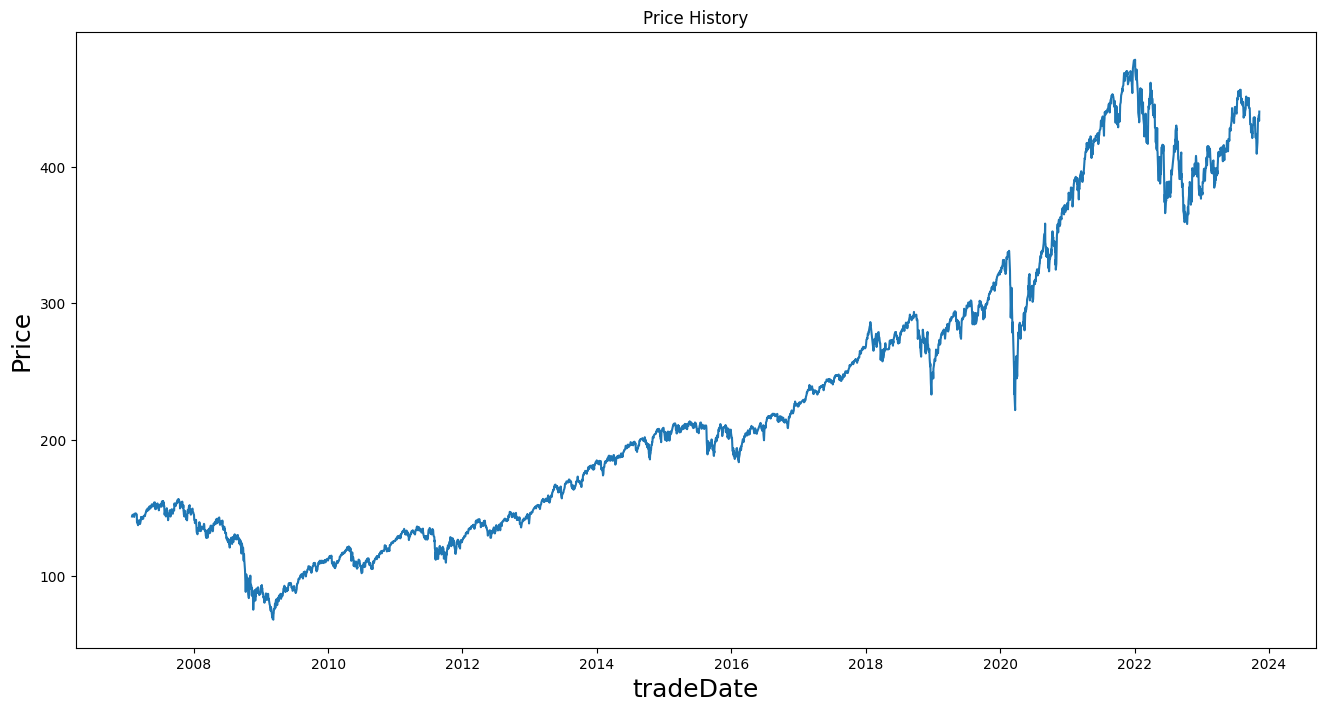

In [11]:
#check the graph of the selected features
plt.figure(figsize=(16,8))
plt.title('Price History')
#Give the plot the data (the price of the stock)
plt.plot(df['pxAtmIv'])
#label the axis
plt.xlabel('tradeDate', fontsize=18)
plt.ylabel('Price', fontsize=18)
#show the plot
plt.show()

In [12]:
#select the dates required for prediction
split_date = pd.Timestamp('2021-04-01')

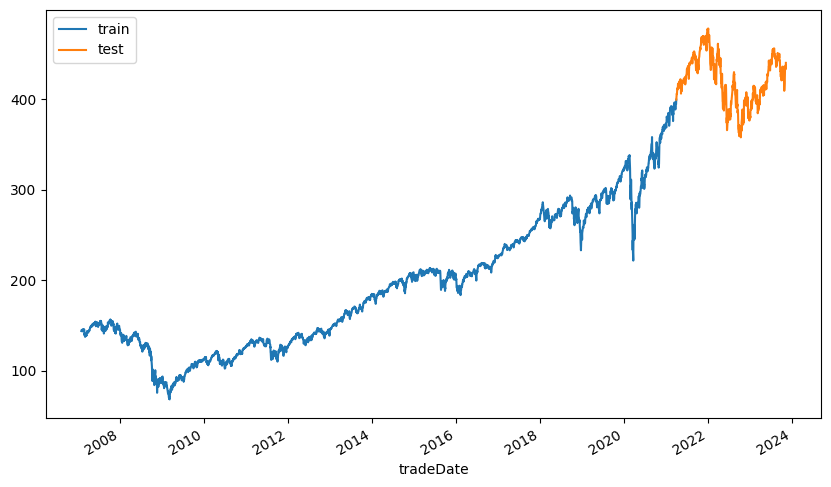

In [13]:
#plot graph from train and test data
df =  df['pxAtmIv']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [14]:
train

tradeDate
2007-01-31    143.75
2007-02-01    144.61
2007-02-02    144.81
2007-02-05    144.85
2007-02-06    144.89
               ...  
2021-03-26    393.54
2021-03-29    395.83
2021-03-30    394.64
2021-03-31    396.71
2021-04-01    399.82
Name: pxAtmIv, Length: 3495, dtype: float64

In [15]:
#scale the values so it can be readable by the model
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(np.array(train).reshape(-1,1))
test_sc = scaler.transform(np.array(test).reshape(-1,1))


In [16]:
train_sc

array([[-0.54393898],
       [-0.53875373],
       [-0.53754786],
       ...,
       [ 0.9687679 ],
       [ 0.98124868],
       [ 1.        ]])

In [17]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [18]:
#create artificial neural network model
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
3494/3494 [==============================] - 10s 2ms/step - loss: 3.8785e-04
Epoch 2/100
3494/3494 [==============================] - 9s 2ms/step - loss: 3.0565e-04
Epoch 3/100
3494/3494 [==============================] - 8s 2ms/step - loss: 2.7171e-04
Epoch 4/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.7645e-04
Epoch 5/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.7020e-04
Epoch 6/100
3494/3494 [==============================] - 6s 2ms/step - loss: 2.6038e-04
Epoch 7/100
3494/3494 [==============================] - 11s 3ms/step - loss: 2.5723e-04
Epoch 8/100
3494/3494 [==============================] - 9s 2ms/step - loss: 2.5854e-04
Epoch 9/100
3494/3494 [==============================] - 8s 2ms/step - loss: 2.5670e-04
Epoch 10/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.5617e-04
Epoch 11/100
3494/3494 [==============================] - 13s 4ms/step - loss: 2.5514e-04
Epoch 12/100
3494/3494 [

In [19]:
#predict the values and generate the R2 score
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

110/110 [==============================] - 0s 3ms/step
The R2 score on the Train set is:	0.967
The R2 score on the Test set is:	0.939


In [20]:

# Assuming train_sc and test_sc are numpy arrays or pandas DataFrames with a column named 'Y'
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)


# Adjust the range to create lag features for more than one time step
for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

# Drop rows with NaN values introduced by the shift operation
X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)


# Convert DataFrames to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [21]:
#Reshape the values so it can be readable by LSTM model
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (3494, 1, 1)
Test shape:  (629, 1, 1)


In [22]:
y_test.shape

(629, 1)

In [23]:
print( X_train_lmse.shape[0])

3494


In [24]:
#create LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])



Epoch 1/100
3494/3494 [==============================] - 19s 5ms/step - loss: 0.0053
Epoch 2/100
3494/3494 [==============================] - 17s 5ms/step - loss: 5.3278e-04
Epoch 3/100
3494/3494 [==============================] - 14s 4ms/step - loss: 2.8220e-04
Epoch 4/100
3494/3494 [==============================] - 17s 5ms/step - loss: 2.6768e-04
Epoch 5/100
3494/3494 [==============================] - 16s 4ms/step - loss: 2.6014e-04
Epoch 6/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.5475e-04
Epoch 7/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.5150e-04
Epoch 8/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.4651e-04
Epoch 9/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.4426e-04
Epoch 10/100
3494/3494 [==============================] - 10s 3ms/step - loss: 2.4268e-04
Epoch 11/100
3494/3494 [==============================] - 8s 2ms/step - loss: 2.4046e-04
Epoch 12/100
3494/3494 [

In [25]:
#predict the values and generate the R2 score
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

110/110 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.946
The R2 score on the Test set is:	0.830


In [26]:
#Evaluate the model with Mean Squared Error
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

629/629 [==============================] - 1s 2ms/step - loss: 0.0042
NN: 0.001507
LSTM: 0.004169


In [27]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

20/20 [==============================] - 0s 2ms/step


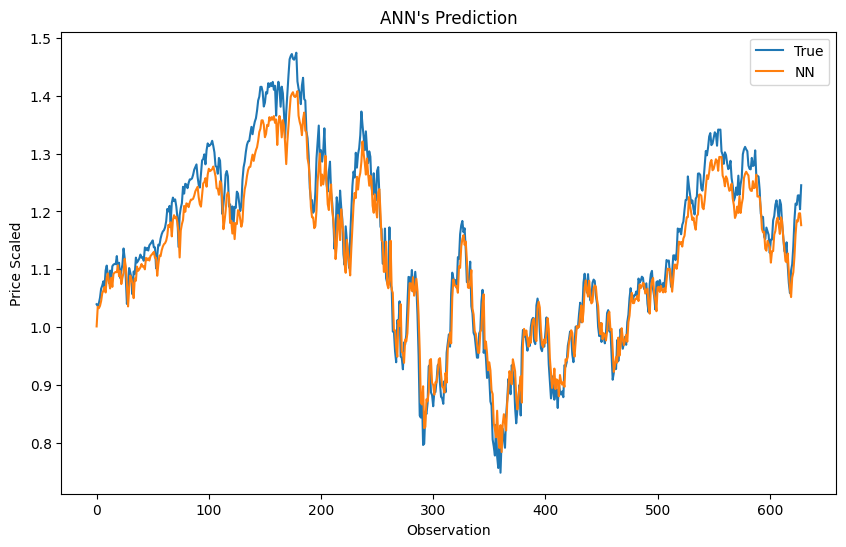

In [28]:
#Plot the graph for ANN's prediction with the Scaled price value
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Price Scaled')
plt.legend()
plt.show();

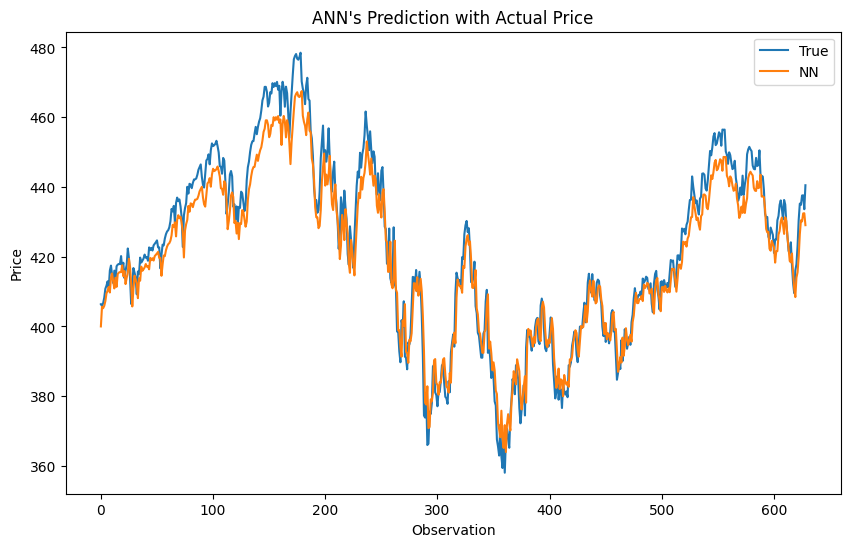

In [31]:
#Plot the graph for ANN's prediction with the Actual price value
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(scaler.inverse_transform(y_pred_test_nn), label='NN')
plt.title("ANN's Prediction with Actual Price")
plt.xlabel('Observation')
plt.ylabel('Price')
plt.legend()
plt.show();

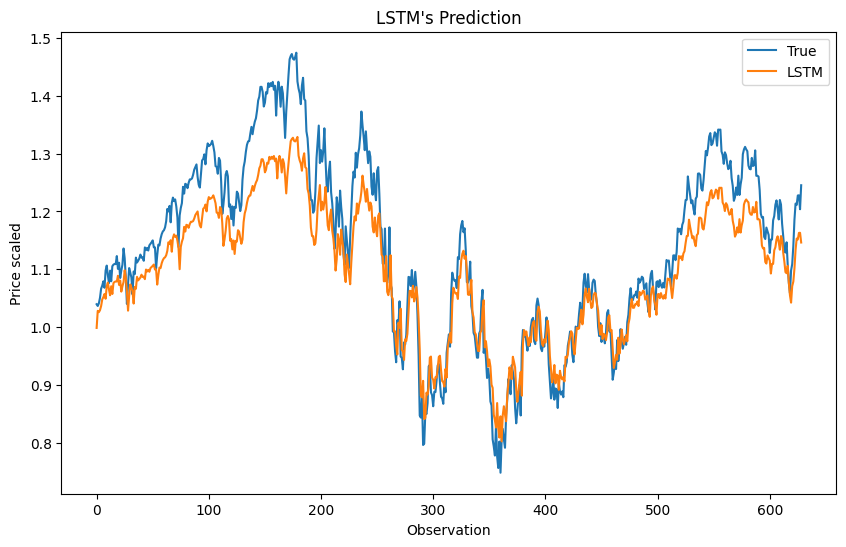

In [32]:
#Plot the graph for LSTM's prediction with the Scaled price value
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Price scaled')
plt.legend()
plt.show();

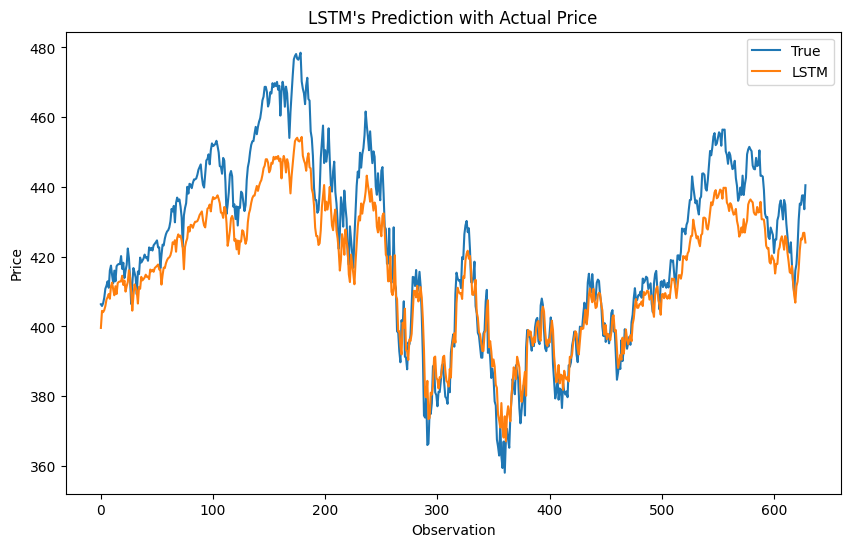

In [33]:
#Plot the graph for LSTM's prediction with the Actual price value
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(scaler.inverse_transform(y_pred_test_lstm), label='LSTM')
plt.title("LSTM's Prediction with Actual Price")
plt.xlabel('Observation')
plt.ylabel('Price')
plt.legend()
plt.show();